Building an Image Classifier using CNN

#Setup

In [6]:
import kagglehub
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
 
import os
import shutil
from sklearn.model_selection import train_test_split
 

path = r".\kagglehub\datasets\andrewmvd\medical-mnist\versions\1"

print(path)
print(os.path.isdir(path))

#path = kagglehub.dataset_download("andrewmvd/medical-mnist")




.\kagglehub\datasets\andrewmvd\medical-mnist\versions\1
True


# Load a dataset

In [ ]:


# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(64, 64),
    color_mode = "grayscale",
    batch_size=32,
    class_mode='categorical',
    subset = "training")  # For multi-class classification

validation_generator = validation_datagen.flow_from_directory(
    path,
    target_size=(64, 64),
    color_mode = "grayscale",
    batch_size=32,
    class_mode='categorical',
    subset = "validation")

Found 58954 images belonging to 6 classes.
Found 11790 images belonging to 6 classes.


# Build a neural network model

In [3]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Output layer with 6 classes
])


c:\Users\seaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,398 (2.61 MB)

 Trainable params: 683,398 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

#compiling the model:


In [5]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [6]:
# Check the output of flow_from_directory
print(f"Train generator classes: {train_generator.class_indices}")
print(f"Validation generator classes: {validation_generator.class_indices}")

# Check batch sizes and data shapes
for batch, labels in train_generator:
    print(f"Batch shape: {batch.shape}, Label shape: {labels.shape}")
    break  # Just inspect the first batch


Train generator classes: {'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}
Validation generator classes: {'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}
Batch shape: (32, 64, 64, 1), Label shape: (32, 6)


# training neural network model:


In [7]:
history = model.fit(train_generator, epochs=5, validation_data = validation_generator, shuffle=True)

Epoch 1/5


c:\Users\seaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1843/1843 ━━━━━━━━━━━━━━━━━━━━ 293s 158ms/step - accuracy: 0.8822 - loss: 0.3043 - val_accuracy: 0.9972 - val_loss: 0.0071
Epoch 2/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9884 - loss: 0.0386 - val_accuracy: 0.9991 - val_loss: 0.0032
Epoch 3/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9956 - loss: 0.0146 - val_accuracy: 0.9991 - val_loss: 0.0037
Epoch 4/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - accuracy: 0.9962 - loss: 0.0136 - val_accuracy: 0.9995 - val_loss: 0.0019
Epoch 5/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 61s 33ms/step - accuracy: 0.9951 - loss: 0.0173 - val_accuracy: 0.9998 - val_loss: 3.8932e-04


#Evaluation



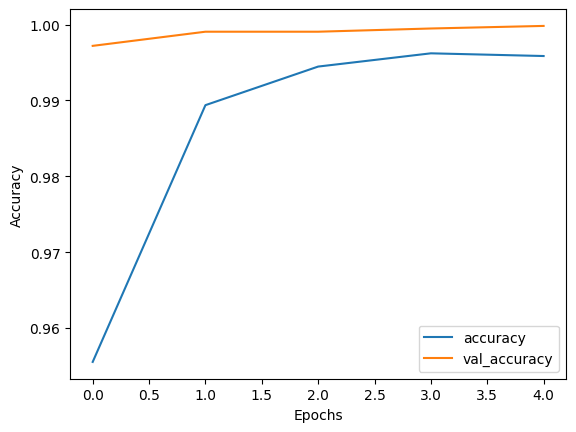

369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9998 - loss: 3.7291e-04
Test Accuracy: 0.9998303651809692


In [8]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model
model.save('image_classifier_model.h5')

# Test the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_accuracy}')


In [10]:
# Checking if value exists
"""print(val_dir)
print(os.path.exists(val_dir + r"\HeadCT\000019.jpeg"))

print(f"{model.input_shape}")
print(img_array.shape)"""

'print(val_dir)\nprint(os.path.exists(val_dir + r"\\HeadCT\x00019.jpeg"))\n\nprint(f"{model.input_shape}")\nprint(img_array.shape)'

#Predicting the first three images from the test set


1.   print the predicted results of the first three images from the test set
2.   print the real label of the first three images from the test set



In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = path + r"\HeadCT\000019.jpeg"
img = image.load_img(img_path, target_size=(64, 64), color_mode = "grayscale")
img_array = image.img_to_array(img) 
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

img_array /= 255.0

print(img_array.shape) # shape should be (1, 64, 64, 1)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f'Predicted Class: {predicted_class}')
#this should be the difference to chang this



(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted Class: 5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<Figure size 720x240 with 0 Axes>

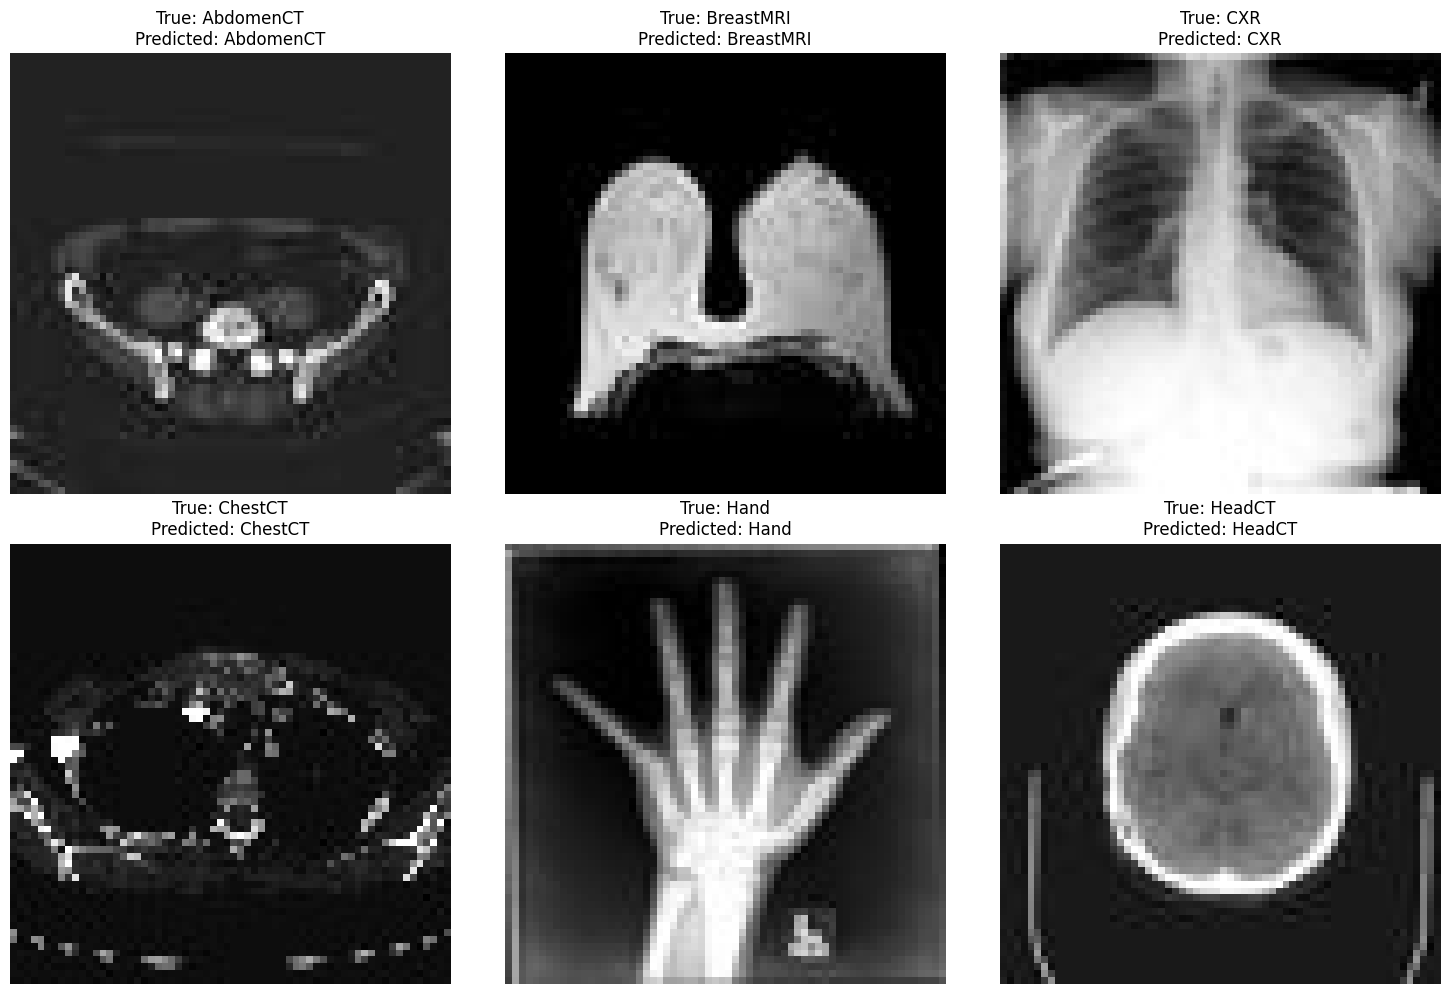

In [16]:
import random
plt.figure(figsize=(7.2, 2.4))
base_dir = path

classes = ["AbdomenCT", "BreastMRI", "CXR","ChestCT",  "Hand", "HeadCT"]

fig, axes = plt.subplots(2 ,3, figsize = (15, 10))

axes = axes.flatten()

for i, cls in enumerate(classes):
    class_dir = f"{base_dir}/{cls}"
    img_name = random.choice(os.listdir(class_dir))
    img_path = f"{class_dir}/{img_name}"

    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64), color_mode='grayscale')
    img_array = img_to_array(img)  # Shape: (64, 64, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 64, 64, 1)
    img_array = img_array / 255.0  # Normalize

    # Get prediction from the model
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = classes[predicted_class]

    # Plot the image
    axes[i].imshow(img_array.squeeze(), cmap='gray')  # Remove extra dimension for display
    axes[i].set_title(f"True: {cls}\nPredicted: {predicted_label}")
    axes[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()  